### Import Packages

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor                   
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from pmdarima import auto_arima

### Import Dataset

In [70]:
df = pd.read_csv("https://raw.githubusercontent.com/globaldothealth/monkeypox/main/latest.csv")
df.head()

C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\769417223.py:1: DtypeWarning: Columns (3,6,7,8,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,27,28,29,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://raw.githubusercontent.com/globaldothealth/monkeypox/main/latest.csv")


,ID,Status,Location,City,Country,Country_ISO3,Age,Gender,Date_onset,Date_confirmation,...,Source,Source_II,Source_III,Source_IV,Source_V,Source_VI,Source_VII,Date_entry,Date_death,Date_last_modified
0,N1,confirmed,Guy's and St Thomas Hospital London,London,England,GBR,NaN,NaN,2022-04-29,2022-05-06,...,https://www.gov.uk/government/news/monkeypox-c...,https://www.who.int/emergencies/disease-outbre...,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18
1,N2,confirmed,Guy's and St Thomas Hospital London,London,England,GBR,NaN,NaN,2022-05-05,2022-05-12,...,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18
2,N3,confirmed,London,London,England,GBR,NaN,NaN,2022-04-30,2022-05-13,...,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18
3,N4,confirmed,London,London,England,GBR,NaN,male,NaN,2022-05-15,...,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18
4,N5,confirmed,London,London,England,GBR,NaN,male,NaN,2022-05-15,...,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49321 entries, 0 to 49320
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       49321 non-null  object 
 1   Status                   49321 non-null  object 
 2   Location                 36022 non-null  object 
 3   City                     1273 non-null   object 
 4   Country                  49321 non-null  object 
 5   Country_ISO3             49321 non-null  object 
 6   Age                      2749 non-null   object 
 7   Gender                   2234 non-null   object 
 8   Date_onset               59 non-null     object 
 9   Date_confirmation        46359 non-null  object 
 10  Symptoms                 203 non-null    object 
 11  Hospitalised (Y/N/NA)    303 non-null    object 
 12  Date_hospitalisation     33 non-null     object 
 13  Isolated (Y/N/NA)        427 non-null    object 
 14  Date_isolation        

### Preprocessing

In [72]:
# Drop rows with empty dates 
df.dropna(subset=['Date_entry'], inplace=True)
df['Date_entry'].isnull().sum()

0

In [73]:
# Set date as index
df.Date_entry = pd.to_datetime(df.Date_entry)
df.set_index('Date_entry')

,ID,Status,Location,City,Country,Country_ISO3,Age,Gender,Date_onset,Date_confirmation,...,Confirmation_method,Source,Source_II,Source_III,Source_IV,Source_V,Source_VI,Source_VII,Date_death,Date_last_modified
Date_entry,,,,,,,,,,,,,,,,,,,,,
2022-05-18,N1,confirmed,Guy's and St Thomas Hospital London,London,England,GBR,NaN,NaN,2022-04-29,2022-05-06,...,RT-PCR,https://www.gov.uk/government/news/monkeypox-c...,https://www.who.int/emergencies/disease-outbre...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
2022-05-18,N2,confirmed,Guy's and St Thomas Hospital London,London,England,GBR,NaN,NaN,2022-05-05,2022-05-12,...,RT-PCR,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
2022-05-18,N3,confirmed,London,London,England,GBR,NaN,NaN,2022-04-30,2022-05-13,...,RT-PCR,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
2022-05-18,N4,confirmed,London,London,England,GBR,NaN,male,NaN,2022-05-15,...,NaN,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
2022-05-18,N5,confirmed,London,London,England,GBR,NaN,male,NaN,2022-05-15,...,NaN,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-19,E2915,suspected,Cross River,NaN,Nigeria,NGA,NaN,NaN,NaN,NaN,...,NaN,https://ncdc.gov.ng/themes/common/files/sitrep...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-19
2022-08-19,E2916,suspected,Oyo,NaN,Nigeria,NGA,NaN,NaN,NaN,NaN,...,NaN,https://ncdc.gov.ng/themes/common/files/sitrep...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-19
2022-08-19,E2917,suspected,Kano,NaN,Nigeria,NGA,NaN,NaN,NaN,NaN,...,NaN,https://ncdc.gov.ng/themes/common/files/sitrep...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-19


In [74]:
# Aggregate the cases based on date
df_cnt1 = df[df['Status'] == "confirmed"]
df_cnt = df.groupby(['Date_entry']).count()
df_cnt = df_cnt[['ID', 'Status']]
df_cnt.head()

,ID,Status
Date_entry,,
2022-05-18,63,63
2022-05-19,40,40
2022-05-20,37,37
2022-05-21,44,44
2022-05-22,7,7


In [75]:
df_cnt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2022-05-18 to 2022-08-25
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      82 non-null     int64
 1   Status  82 non-null     int64
dtypes: int64(2)
memory usage: 1.9 KB


In [76]:
# Filter Confirmed Cases
df_cnt1.set_index('Date_entry')
df_cnt1 = df_cnt1.groupby(['Date_entry']).count()
df_cnt1 = df_cnt1[['ID']]
df_cnt1.head()

,ID
Date_entry,
2022-05-18,63
2022-05-19,40
2022-05-20,34
2022-05-21,40
2022-05-22,6


[Text(0.5, 0, 'Dates'), Text(0, 0.5, 'Cases')]

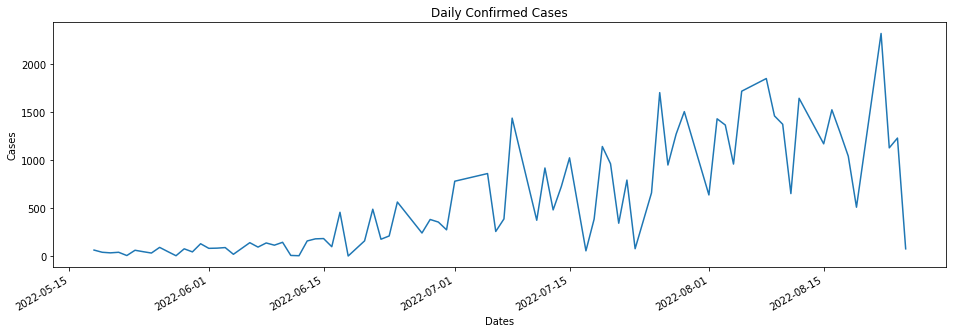

In [77]:
ax = df_cnt1['ID'].plot(figsize = (16,5), title = "Daily Confirmed Cases")
ax.set(xlabel='Dates', ylabel='Cases')

In [78]:
df_cnt1.index = pd.DatetimeIndex(df_cnt1.index).to_period('D')
df_cnt1 = df_cnt1.resample('D').pad()
train_data = df_cnt1[:len(df_cnt1)-12]
test_data = df_cnt1[len(df_cnt1)-12:]

C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\3803592034.py:2: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  df_cnt1 = df_cnt1.resample('D').pad()


### ARIMA

In [79]:
AARIMA = auto_arima(df_cnt1['ID'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4)
print(AARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -728.655
Date:                            Thu, 25 Aug 2022   AIC                           1467.311
Time:                                    21:06:03   BIC                           1480.286
Sample:                                         0   HQIC                          1472.561
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.9035      1.546      7.053      0.000       7.874      13.933
ar.L1          0.3002      0.087   

In [80]:
# Fit the model
arima_model = ARIMA(train_data['ID'], order = (3,2,3))
arima_result = arima_model.fit()
print(arima_result.summary())

c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                     ID   No. Observations:                   88
Model:                 ARIMA(3, 2, 3)   Log Likelihood                -625.083
Date:                Thu, 25 Aug 2022   AIC                           1264.165
Time:                        21:06:03   BIC                           1281.346
Sample:                    05-18-2022   HQIC                          1271.080
                         - 08-13-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8388      0.201     -4.178      0.000      -1.232      -0.445
ar.L2         -1.1555      0.088    -13.196      0.000      -1.327      -0.984
ar.L3         -0.3825      0.196     -1.948      0.0

c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


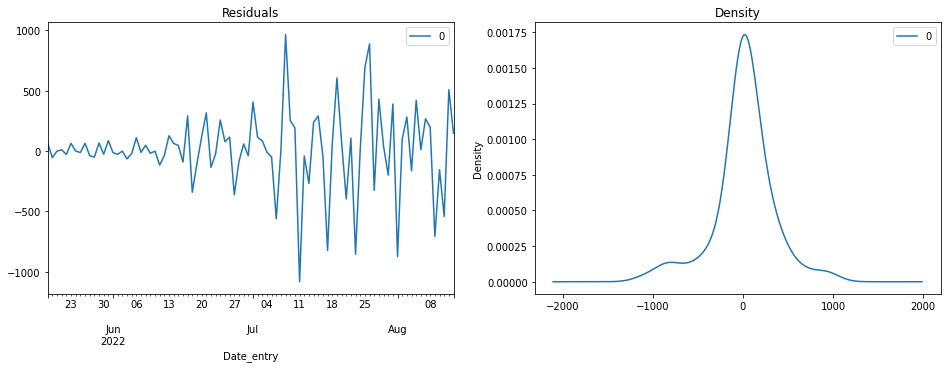

In [81]:
# Plot residual errors
residuals = pd.DataFrame(arima_result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize = (16,5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Text(0.5, 1.0, 'Forecast vs Training')

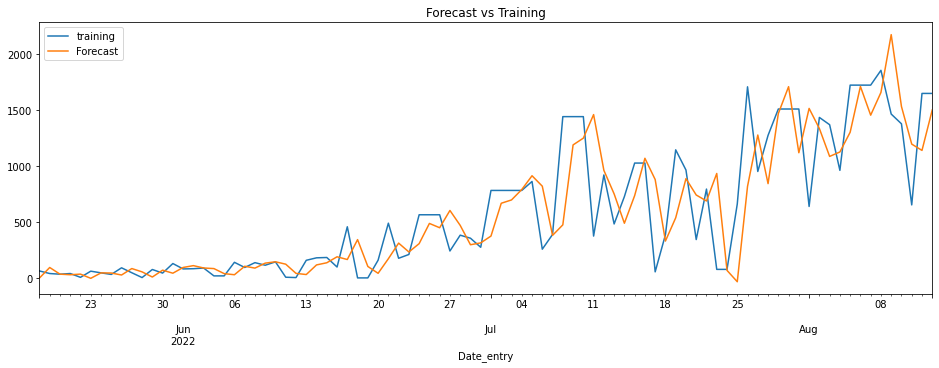

In [82]:
# Test Model Fit
arima_res = arima_result.get_prediction(start = train_data.index[0], end = train_data.index[-1], typ="levels")
arima_pred = arima_res.predicted_mean
train_data['ID'].plot(figsize = (16,5), legend=True, label='training')
arima_pred.plot(figsize = (16,5), legend=True, label='Forecast')
plt.title('Forecast vs Training')

In [83]:
# Predict the test data
arima_res = arima_result.get_prediction(start = test_data.index[0], end = test_data.index[-1], typ="levels")
arima_pred = arima_res.predicted_mean
arima_conf = arima_res.conf_int(alpha=0.05)
lower_series = pd.Series(arima_conf['lower ID'], index=test_data.index)
upper_series = pd.Series(arima_conf['upper ID'], index=test_data.index)

<AxesSubplot:xlabel='Date_entry'>

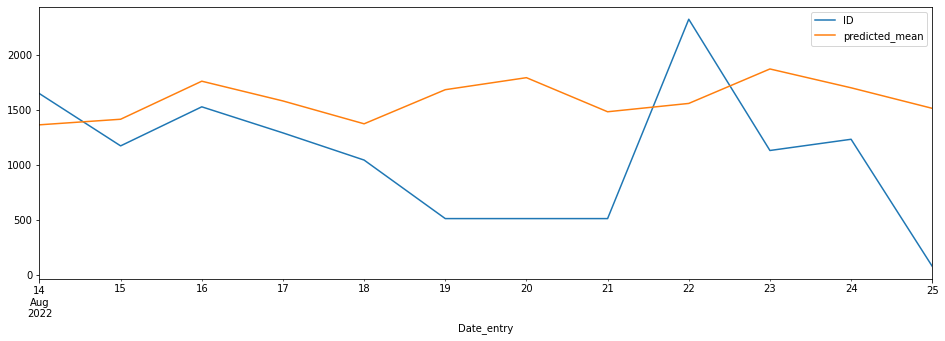

In [84]:
# plot predictions
test_data['ID'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True)

Text(0.5, 1.0, 'Forecast vs Actuals')

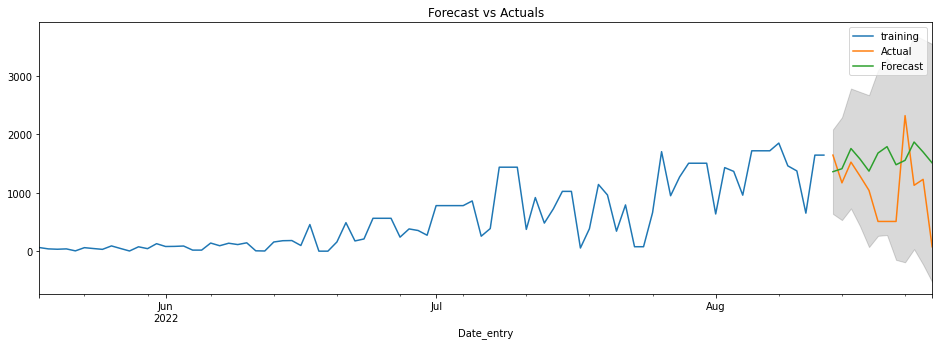

In [85]:
# Compared predictions
train_data['ID'].plot(figsize = (16,5), legend=True, label='training')
test_data['ID'].plot(figsize = (16,5), legend=True, label='Actual')
arima_pred.plot(figsize = (16,5), legend=True, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')

In [86]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]              # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1,'corr':corr, 'minmax':minmax})

forecast_accuracy(arima_pred.values, test_data['ID'])

C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\1940404843.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\1940404843.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)


{'mape': 2.3374754226757557,
 'me': 509.59093043888214,
 'mae': 684.3923456275097,
 'mpe': 2.253834722344232,
 'rmse': 804.1186764605097,
 'acf1': 0.043541612137733256,
 'corr': -0.08841753845389819,
 'minmax': 0.4099008767445047}

### PROPHET

In [87]:
df_fb  = pd.DataFrame({"ds":[],"y":[]})
df_fb_test  = pd.DataFrame({"ds":[],"y":[]})
df_fb["ds"] = pd.to_datetime(train_data.index.to_timestamp())
df_fb["y"]  = train_data.iloc[:,0].values
df_fb_test["ds"] = pd.to_datetime(test_data.index.to_timestamp())
df_fb_test["y"]  = test_data.iloc[:,0].values

m = Prophet()
m.fit(df_fb)
future = m.make_future_dataframe(periods=len(df_fb_test.index),freq='D')
prophet_pred = m.predict(future)

21:06:05 - cmdstanpy - INFO - Chain [1] start processing
21:06:05 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-len(df_fb_test.index):]['ds'], "Pred" : prophet_pred[-len(df_fb_test.index):]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "D"
prophet_pred

,Pred
Date,
2022-08-14,1350.362645
2022-08-15,1287.444555
2022-08-16,1566.505744
2022-08-17,1387.377244
2022-08-18,1297.368472
2022-08-19,1681.691491
2022-08-20,1572.755366
2022-08-21,1478.005943
2022-08-22,1415.087853


<AxesSubplot:xlabel='Date'>

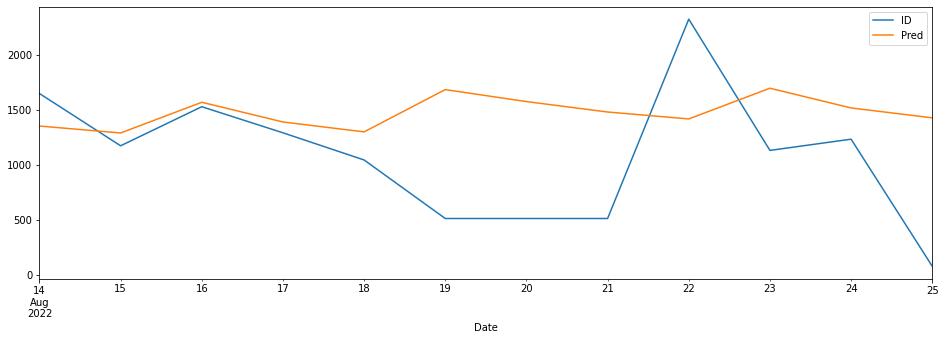

In [89]:
# plot predictions
test_data['ID'].plot(figsize = (16,5), legend=True)
prophet_pred['Pred'].plot(legend = True)

Text(0.5, 1.0, 'Forecast vs Actuals')

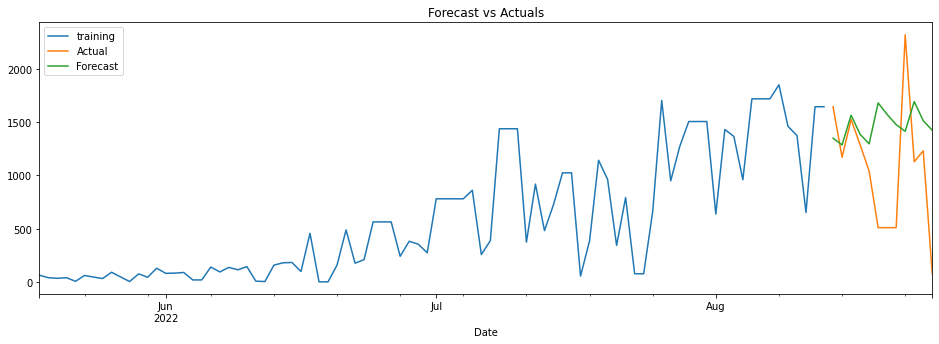

In [90]:
# Compared predictions
train_data['ID'].plot(figsize = (16,5), legend=True, label='training')
test_data['ID'].plot(figsize = (16,5), legend=True, label='Actual')
prophet_pred['Pred'].plot(figsize = (16,5), legend=True, label='Forecast')
plt.title('Forecast vs Actuals')

In [91]:
forecast_accuracy(prophet_pred['Pred'].values, test_data['ID'])

C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\1940404843.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\1940404843.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)


{'mape': 2.148194633107966,
 'me': 392.3983891150019,
 'mae': 592.8233061188927,
 'mpe': 2.0531640866936427,
 'rmse': 744.9396825656426,
 'acf1': 0.028568759767538608,
 'corr': -0.2613937727683919,
 'minmax': 0.370779983899323}

### Proposed Model

In [92]:
# Arima Rolling Forecast
predicted1, resid_test = [], []
history = train_data.values
history = list(history)
test = test_data.values
for t in range(len(test)):
    model = ARIMA(history, order=(9,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    resid_test.append(test[t] - output[0])
    predicted1.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1518.212208, expected=1646.000000
predicted=1459.311111, expected=1171.000000
predicted=1274.000535, expected=1526.000000
predicted=1321.907684, expected=1289.000000
predicted=1165.393102, expected=1042.000000
predicted=1341.326305, expected=510.000000
predicted=1083.930211, expected=510.000000
predicted=807.519158, expected=510.000000
predicted=652.297541, expected=2322.000000
predicted=1685.858647, expected=1129.000000
predicted=1060.020652, expected=1231.000000
predicted=872.601613, expected=76.000000


Test MSE: 420840.700


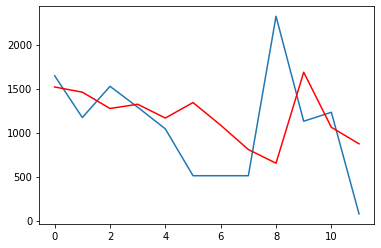

In [93]:
test_resid = []
for i in resid_test:
    test_resid.append(i[0])
error = mean_squared_error(test, predicted1)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predicted1, color='red')
plt.show()

In [94]:
window_size = 6
def make_model(window_size):
    model = Sequential()
    model.add(Dense(50, input_dim=window_size, activation="tanh"))
    model.add(Dense(25, activation="tanh"))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [95]:
model = make_model(6)
min_max_scaler = preprocessing.MinMaxScaler()
train = train_data.values
train = np.array(train).reshape(-1,1)
train_scaled = min_max_scaler.fit_transform(test)

In [96]:
train_X,train_Y = [],[]
for i in range(0 , len(train_scaled) - window_size):
    train_X.append(train_scaled[i:i+window_size])
    train_Y.append(train_scaled[i+window_size])
new_train_X,new_train_Y = [],[]
for i in train_X:
    new_train_X.append(i.reshape(-1))
for i in train_Y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_Y = np.array(new_train_Y)
model.fit(new_train_X,new_train_Y, epochs=100, batch_size=512, validation_split = .05)

Epoch 1/100
1/1 [==============================] - 0s 450ms/step - loss: 0.2033 - val_loss: 0.0117
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1509 - val_loss: 0.0342
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 0.1152 - val_loss: 0.0657
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0953 - val_loss: 0.1008
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0889 - val_loss: 0.1319
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0915 - val_loss: 0.1521
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0975 - val_loss: 0.1580
Epoch 8/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1022 - val_loss: 0.1506
Epoch 9/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1032 - val_loss: 0.1333
Epoch 10/100
1/1 [==============================] - 0s 23ms/step - loss: 0.1003 - val_loss: 0.1100
Epoch 11/100
1/1 [

In [97]:
test_extended = train.tolist()[-1*window_size:] + test_resid
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
test_scaled = min_max_scaler.fit_transform(test_data)


In [98]:
test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])
    new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)

1/1 [==============================] - 0s 43ms/step


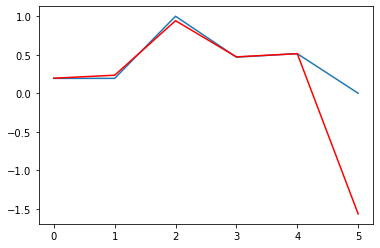

Test MSE: 3438227.731


In [99]:
predictions = model.predict(new_train_X)
predictions_rescaled=min_max_scaler.inverse_transform(predictions)
Y = pd.DataFrame(new_train_Y)
pred = pd.DataFrame(predictions)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
test_resid = test_resid[0:6]
error = mse(test_resid,predictions_rescaled)
print('Test MSE: %.3f' % error)

In [100]:
forecast_accuracy(predictions, new_train_Y)

C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\1940404843.py:3: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\1940404843.py:6: RuntimeWarning: divide by zero encountered in true_divide
  mpe = np.mean((forecast - actual)/actual)   # MPE
c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\balaj\AppData\Local\Temp\ipykernel_11044\19

{'mape': inf,
 'me': -0.2629333282855435,
 'mae': 0.2786608043760636,
 'mpe': -inf,
 'rmse': 0.640294616104715,
 'acf1': -0.036678018974039155,
 'corr': nan,
 'minmax': inf}